# Importing libraries

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn.feature_extraction import FeatureHasher
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [10]:
np.random.seed(42)
tf.random.set_seed(42)


# loading dataset

In [13]:
file_path = r"C:\Users\kanti\Downloads\DDOS Dataset.csv"
print("Loading dataset...")
df = pd.read_csv(file_path)
print(f"Original dataset size: {len(df)} rows, {len(df.columns)} columns")

Loading dataset...
Original dataset size: 15462150 rows, 26 columns


In [15]:
df = df.drop(columns=['flow_id', 'ip_src', 'ip_dst'], errors='ignore')

# Replace infinity with NaN and drop NaN rows

In [18]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print(f"Dataset size after dropping NaN rows: {len(df)} rows")

Dataset size after dropping NaN rows: 2667523 rows


# Drop constant columns

In [21]:
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
if constant_columns:
    print(f"Dropping constant columns: {constant_columns}")
    df = df.drop(columns=constant_columns, inplace=False)

Dropping constant columns: ['idle_timeout', 'hard_timeout', 'FIN_Flag_Cnt', 'SYN_Flag_Cnt', 'RST_Flag_Cnt', 'PSH_Flag_Cnt', 'ACK_Flag_Cnt', 'URG_Flag_Cnt', 'CWE_Flag_Cnt', 'ECE_Flag_Cnt']


# Feature Hashing for high-cardinality columns

In [24]:
categorical_cols = ['flow_id', 'ip_src', 'ip_dst']
high_cardinality_cols = ['flow_id', 'ip_src']
existing_high_cardinality_cols = [col for col in high_cardinality_cols if col in df.columns]
if existing_high_cardinality_cols:
    hasher = FeatureHasher(n_features=5, input_type='string')
    hashed_features = hasher.transform(df[existing_high_cardinality_cols].astype(str).to_dict('records'))
    df_hashed = pd.DataFrame(hashed_features.toarray(), columns=[f'hash_{i}' for i in range(5)])
    df = df.drop(columns=existing_high_cardinality_cols)
    df = pd.concat([df, df_hashed], axis=1)
    print(f"Applied Feature Hashing to {existing_high_cardinality_cols}")
else:
    print("No high-cardinality categorical columns found in dataset.")

No high-cardinality categorical columns found in dataset.


# Scaling numeric features

In [27]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('label')
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
print(f"Number of numeric columns after preprocessing: {len(numeric_cols)}")
print(f"Numeric columns: {numeric_cols.tolist()}")

Number of numeric columns after preprocessing: 12
Numeric columns: ['timestamp', 'tp_src', 'tp_dst', 'ip_proto', 'flow_duration_sec', 'flow_duration_nsec', 'packet_count', 'byte_count', 'packet_count_per_second', 'packet_count_per_nsecond', 'byte_count_per_second', 'byte_count_per_nsecond']


# Encode labels if necessary

In [30]:
if df['label'].dtype == 'object':
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])

# Feature Selection based on Correlation

In [33]:
correlation_with_target = df.corr()['label'].drop('label')
correlation_threshold = 0.1
selected_features = correlation_with_target[abs(correlation_with_target) >= correlation_threshold].index.tolist()
dropped_features = correlation_with_target[abs(correlation_with_target) < correlation_threshold].index.tolist()
df = df[selected_features + ['label']]
print("\nSelected Features (Correlation >= 0.1):")
print(selected_features)
print("\nDropped Features (Correlation < 0.1):")
print(dropped_features)
print(f"\nFinal dataset shape after feature selection: {df.shape}")


Selected Features (Correlation >= 0.1):
['timestamp', 'tp_dst', 'ip_proto', 'flow_duration_sec', 'packet_count', 'byte_count', 'packet_count_per_second', 'byte_count_per_second']

Dropped Features (Correlation < 0.1):
['tp_src', 'flow_duration_nsec', 'packet_count_per_nsecond', 'byte_count_per_nsecond']

Final dataset shape after feature selection: (2667523, 9)


# randomize dataset shuffles dataset to remove order bias

In [36]:
df = shuffle(df, random_state=42)
print("Dataset randomized")

Dataset randomized


# Prepare features and target

In [39]:
X = df.drop(columns=['label']).values
y = df['label'].values
print(f"Shape of X after preprocessing: {X.shape}")

Shape of X after preprocessing: (2667523, 8)


# Split dataset

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {len(X_train)} rows, Test set size: {len(X_test)} rows")
print(f"Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}")

Training set size: 2134018 rows, Test set size: 533505 rows
Shape of X_train: (2134018, 8), Shape of X_test: (533505, 8)


# Training ANN Model before combining adversial samples

In [45]:
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    Dropout(0.6),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    Dense(1, activation='sigmoid')
])
ann_model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
ann_history = ann_model.fit(X_train, y_train, epochs=8, batch_size=256, validation_data=(X_test, y_test), verbose=1)

C:\Users\kanti\anacondanav\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
8337/8337 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8674 - loss: 0.5902 - precision: 0.8427 - recall: 0.9850 - val_accuracy: 0.9204 - val_loss: 0.3218 - val_precision: 0.8924 - val_recall: 1.0000
Epoch 2/8
8337/8337 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9181 - loss: 0.3282 - precision: 0.8949 - recall: 0.9924 - val_accuracy: 0.9308 - val_loss: 0.2918 - val_precision: 0.9051 - val_recall: 1.0000
Epoch 3/8
8337/8337 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9284 - loss: 0.3013 - precision: 0.9064 - recall: 0.9940 - val_accuracy: 0.9387 - val_loss: 0.2709 - val_precision: 0.9151 - val_recall: 1.0000
Epoch 4/8
8337/8337 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9372 - loss: 0.2822 - precision: 0.9156 - recall: 0.9966 - val_accuracy: 0.9438 - val_loss: 0.2562 - val_precision: 0.9216 - val_recall: 1.0000
Epoch 5/8
8337/8337 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9426 - loss: 0.2684 - precision: 0.9213 - recall: 0.9981 - val_accuracy: 0.9478 - va

# Evaluate ANN on original dataset

In [48]:
loss, accuracy, precision, recall = ann_model.evaluate(X_test, y_test, verbose=0)
print(f"\nANN Test Loss: {loss:.4f}")
print(f"ANN Test Accuracy: {accuracy:.4f}")
print(f"ANN Test Precision: {precision:.4f}")
print(f"ANN Test Recall: {recall:.4f}")
y_pred_ann = (ann_model.predict(X_test, verbose=0) > 0.5).astype("int32")
ann_f1 = f1_score(y_test, y_pred_ann)
print(f"ANN Test F1-Score: {ann_f1:.4f}")
ann_conf_matrix = confusion_matrix(y_test, y_pred_ann)
print("\nANN Confusion Matrix:")
print(ann_conf_matrix)


ANN Test Loss: 0.2233
ANN Test Accuracy: 0.9551
ANN Test Precision: 0.9363
ANN Test Recall: 1.0000
ANN Test F1-Score: 0.9671

ANN Confusion Matrix:
[[157315  23959]
 [     7 352224]]


# Defining FGSM attack function 

In [61]:
def fgsm_attack(model, X, y, epsilon=0.1, batch_size=1024):
    X_adv = np.zeros_like(X)
    for i in range(0, len(X), batch_size):
        batch_end = min(i + batch_size, len(X))
        X_batch = tf.convert_to_tensor(X[i:batch_end], dtype=tf.float32)
        y_batch = y[i:batch_end]
        y_batch = tf.expand_dims(y_batch, axis=-1)
        with tf.GradientTape() as tape:
            tape.watch(X_batch)
            predictions = model(X_batch, training=False)
            loss = tf.keras.losses.binary_crossentropy(y_batch, predictions)
            loss = tf.reduce_mean(loss)
        gradient = tape.gradient(loss, X_batch)
        signed_grad = tf.sign(gradient)
        X_adv_batch = X_batch + epsilon * signed_grad
        X_adv_batch = tf.clip_by_value(X_adv_batch, 0, 1)
        X_adv[i:batch_end] = X_adv_batch.numpy()
        print(f"Processed batch {i//batch_size + 1}/{(len(X)//batch_size) + 1}")
    return X_adv

# Training Base Model for FGSM

In [64]:
print("\nTraining a base model for FGSM attack...")
base_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
base_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
base_model.fit(X_train, y_train, epochs=5, batch_size=1024, validation_data=(X_test, y_test), verbose=1)


Training a base model for FGSM attack...
Epoch 1/5


C:\Users\kanti\anacondanav\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2085/2085 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9392 - loss: 0.1930 - val_accuracy: 0.9774 - val_loss: 0.0784
Epoch 2/5
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9785 - loss: 0.0728 - val_accuracy: 0.9872 - val_loss: 0.0422
Epoch 3/5
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9888 - loss: 0.0437 - val_accuracy: 0.9927 - val_loss: 0.0296
Epoch 4/5
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9930 - loss: 0.0327 - val_accuracy: 0.9947 - val_loss: 0.0208
Epoch 5/5
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9946 - loss: 0.0257 - val_accuracy: 0.9954 - val_loss: 0.0170


# Generating FGSM Adversarial Examples for the Entire Dataset

In [67]:
print("\nGenerating FGSM adversarial examples for the entire training set...")
X_train_adv = fgsm_attack(base_model, X_train, y_train, epsilon=0.1, batch_size=1024)
print(f"Shape of X_train_adv: {X_train_adv.shape}")
print("Generating FGSM adversarial examples for the entire test set...")
X_test_adv = fgsm_attack(base_model, X_test, y_test, epsilon=0.1, batch_size=1024)
print(f"Shape of X_test_adv: {X_test_adv.shape}")


Generating FGSM adversarial examples for the entire training set...
Processed batch 1/2085
Processed batch 2/2085
Processed batch 3/2085
Processed batch 4/2085
Processed batch 5/2085
Processed batch 6/2085
Processed batch 7/2085
Processed batch 8/2085
Processed batch 9/2085
Processed batch 10/2085
Processed batch 11/2085
Processed batch 12/2085
Processed batch 13/2085
Processed batch 14/2085
Processed batch 15/2085
Processed batch 16/2085
Processed batch 17/2085
Processed batch 18/2085
Processed batch 19/2085
Processed batch 20/2085
Processed batch 21/2085
Processed batch 22/2085
Processed batch 23/2085
Processed batch 24/2085
Processed batch 25/2085
Processed batch 26/2085
Processed batch 27/2085
Processed batch 28/2085
Processed batch 29/2085
Processed batch 30/2085
Processed batch 31/2085
Processed batch 32/2085
Processed batch 33/2085
Processed batch 34/2085
Processed batch 35/2085
Processed batch 36/2085
Processed batch 37/2085
Processed batch 38/2085
Processed batch 39/2085
Proc

# Saving Adversarial Dataset

In [69]:
print("\nSaving adversarial dataset")
try:
    adv_data = np.vstack([X_train_adv, X_test_adv])
    print(f"Shape of combined adversarial data: {adv_data.shape}")
    adv_df = pd.DataFrame(adv_data, columns=selected_features)
    adv_df['label'] = np.hstack([y_train, y_test])
    adv_df.to_csv('adversarial_dataset.csv', index=False)
    print(f"Saved FGSM adversarial dataset with {len(adv_df)} rows as 'adversarial_dataset.csv'!")
    if os.path.exists('adversarial_dataset.csv'):
        file_size = os.path.getsize('adversarial_dataset.csv') / (1024 * 1024)
        print(f"File size: {file_size:.2f} MB")
except Exception as e:
    print(f"Error saving adversarial dataset: {str(e)}")


Saving adversarial dataset
Shape of combined adversarial data: (2667523, 8)
Saved FGSM adversarial dataset with 2667523 rows as 'adversarial_dataset.csv'!
File size: 333.44 MB


# Load Adversarial Dataset for Testing

In [71]:
print("\nLoading adversarial dataset for testing")
df_adv = pd.read_csv(r"C:\Users\kanti\Minor_Project\adversarial_dataset.csv")
X_adv = df_adv.drop(columns=['label']).values
y_adv = df_adv['label'].values
print(f"Adversarial dataset shape: {X_adv.shape}")


Loading adversarial dataset for testing
Adversarial dataset shape: (2667523, 8)


# Testing ANN model on Adversarial Dataset

In [73]:
print("\nTesting ANN on adversarial dataset...")
loss, accuracy, precision, recall = ann_model.evaluate(X_adv, y_adv, verbose=0)
print(f"ANN Test Loss (Adversarial Dataset): {loss:.4f}")
print(f"ANN Test Accuracy (Adversarial Dataset): {accuracy:.4f}")
print(f"ANN Test Precision (Adversarial Dataset): {precision:.4f}")
print(f"ANN Test Recall (Adversarial Dataset): {recall:.4f}")
y_pred_ann_adv = (ann_model.predict(X_adv, verbose=0) > 0.5).astype("int32")
ann_f1_adv = f1_score(y_adv, y_pred_ann_adv)
print(f"ANN Test F1-Score (Adversarial Dataset): {ann_f1_adv:.4f}")
ann_conf_matrix_adv = confusion_matrix(y_adv, y_pred_ann_adv)
print("\nANN Confusion Matrix (Adversarial Dataset):")
print(ann_conf_matrix_adv)


Testing ANN on adversarial dataset...
ANN Test Loss (Adversarial Dataset): 2.4626
ANN Test Accuracy (Adversarial Dataset): 0.4639
ANN Test Precision (Adversarial Dataset): 0.7610
ANN Test Recall (Adversarial Dataset): 0.2738
ANN Test F1-Score (Adversarial Dataset): 0.4027

ANN Confusion Matrix (Adversarial Dataset):
[[ 755486  151367]
 [1278597  482073]]


# Combining Adversarial dataset with Original Dataset

In [75]:
print("\nCombining datasets")
X_original = df.drop(columns=['label']).values
y_original = df['label'].values
X_combined = np.vstack([X_original, X_adv])
y_combined = np.hstack([y_original, y_adv])


Combining datasets


# Saving Combined Dataset

In [77]:
print("Saving combined dataset")
combined_df = pd.DataFrame(X_combined, columns=selected_features)
combined_df['label'] = y_combined
combined_df.to_csv('combined_dataset.csv', index=False)
print(f"Saved combined dataset with {len(combined_df)} rows as 'combined_dataset.csv'!")
if os.path.exists('combined_dataset.csv'):
    file_size = os.path.getsize('combined_dataset.csv') / (1024 * 1024)
    print(f"Combined dataset file size: {file_size:.2f} MB")

Saving combined dataset
Saved combined dataset with 5335046 rows as 'combined_dataset.csv'!
Combined dataset file size: 534.85 MB


# Loading Combined Dataset for Testing

In [79]:
print("\nLoading combined dataset for testing")
df_combined = pd.read_csv(r"C:\Users\kanti\Minor_Project\combined_dataset.csv")
X_combined = df_combined.drop(columns=['label']).values
y_combined = df_combined['label'].values
print(f"Combined dataset shape: {X_combined.shape}")


Loading combined dataset for testing
Combined dataset shape: (5335046, 8)


# Testing ANN model on Combined Dataset

In [81]:
print("\nTesting ANN on combined dataset")
loss, accuracy, precision, recall = ann_model.evaluate(X_combined, y_combined, verbose=0)
print(f"ANN Test Loss (Combined Dataset): {loss:.4f}")
print(f"ANN Test Accuracy (Combined Dataset): {accuracy:.4f}")
print(f"ANN Test Precision (Combined Dataset): {precision:.4f}")
print(f"ANN Test Recall (Combined Dataset): {recall:.4f}")
y_pred_ann_combined = (ann_model.predict(X_combined, verbose=0) > 0.5).astype("int32")
ann_f1_combined = f1_score(y_combined, y_pred_ann_combined)
print(f"ANN Test F1-Score (Combined Dataset): {ann_f1_combined:.4f}")
ann_conf_matrix_combined = confusion_matrix(y_combined, y_pred_ann_combined)
print("\nANN Confusion Matrix (Combined Dataset):")
print(ann_conf_matrix_combined)


Testing ANN on combined dataset
ANN Test Loss (Combined Dataset): 1.3427
ANN Test Accuracy (Combined Dataset): 0.7096
ANN Test Precision (Combined Dataset): 0.8922
ANN Test Recall (Combined Dataset): 0.6369
ANN Test F1-Score (Combined Dataset): 0.7432

ANN Confusion Matrix (Combined Dataset):
[[1542853  270853]
 [1278630 2242710]]


# Plotting Confusion Matrices for Original Test Set,Adversarial Dataset & Combined Dataset

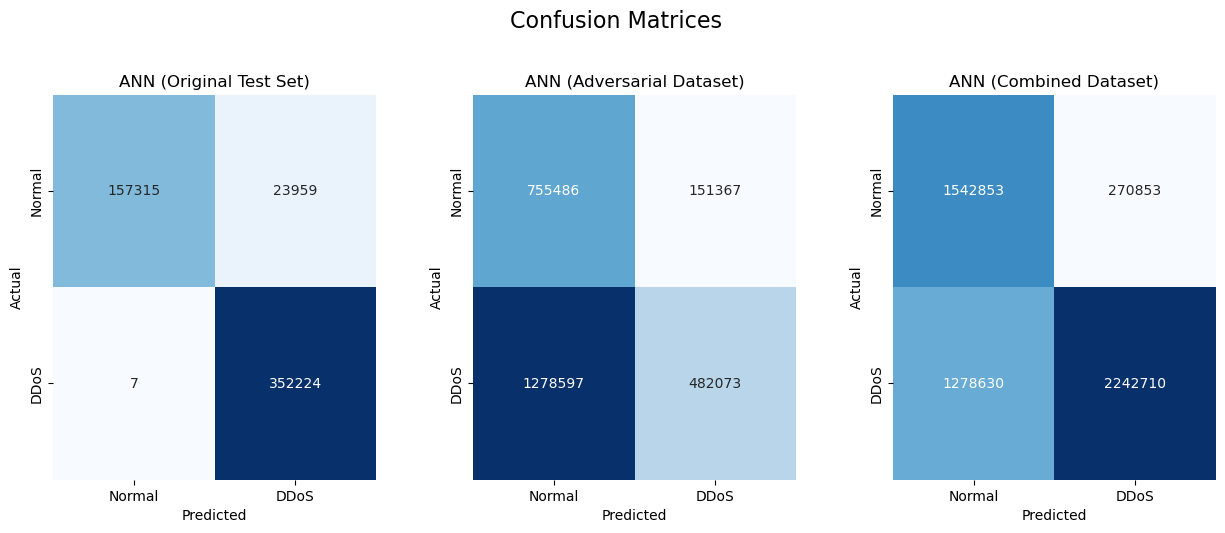

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Confusion Matrices', fontsize=16, y=1.05)

# Original Test Set
sns.heatmap(ann_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            ax=axes[0], xticklabels=['Normal', 'DDoS'], yticklabels=['Normal', 'DDoS'],
            cbar=False)
axes[0].set_title('ANN (Original Test Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Adversarial Dataset
sns.heatmap(ann_conf_matrix_adv, annot=True, fmt='d', cmap='Blues', 
            ax=axes[1], xticklabels=['Normal', 'DDoS'], yticklabels=['Normal', 'DDoS'],
            cbar=False)
axes[1].set_title('ANN (Adversarial Dataset)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Combined Dataset
sns.heatmap(ann_conf_matrix_combined, annot=True, fmt='d', cmap='Blues', 
            ax=axes[2], xticklabels=['Normal', 'DDoS'], yticklabels=['Normal', 'DDoS'],
            cbar=False)
axes[2].set_title('ANN (Combined Dataset)')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.subplots_adjust(wspace=0.3)
plt.show()

# plotting ROC Curves

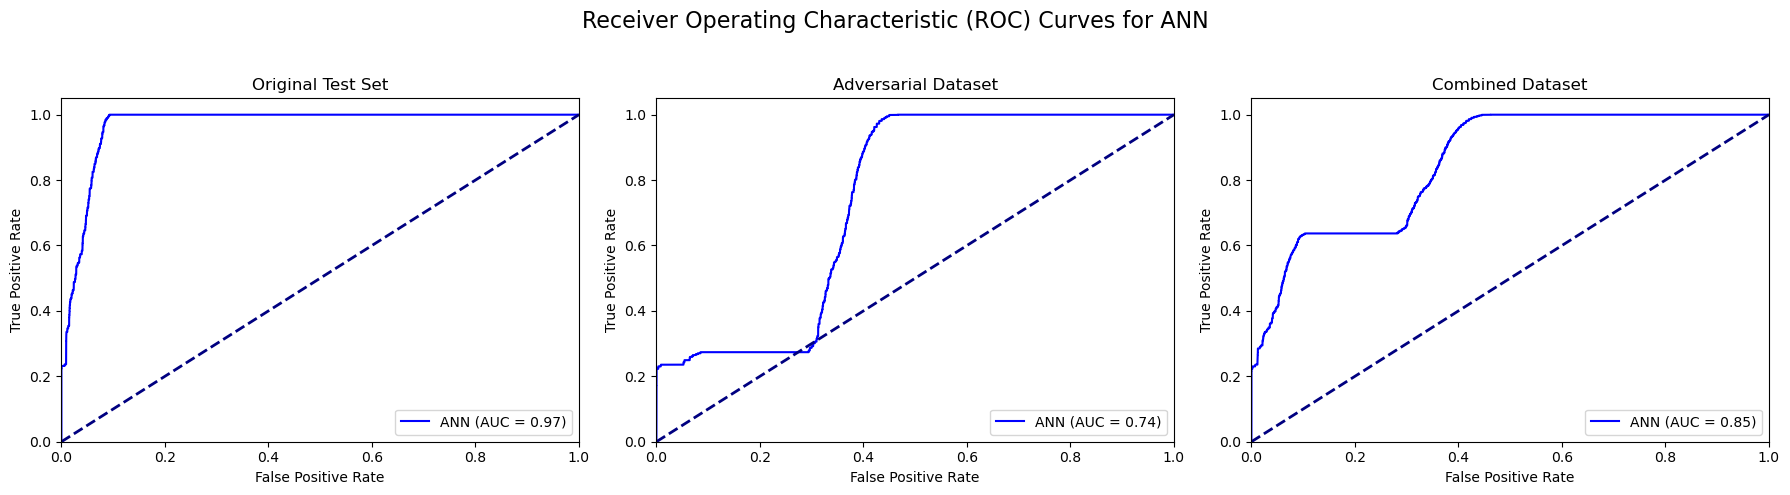

In [107]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Plot ROC Curves for ANN only
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Receiver Operating Characteristic (ROC) Curves for ANN', fontsize=16)

# Original Test Set
y_pred_prob_ann_orig = ann_model.predict(X_test, verbose=0).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_ann_orig)
roc_auc = roc_auc_score(y_test, y_pred_prob_ann_orig)
axes[0].plot(fpr, tpr, label=f"ANN (AUC = {roc_auc:.2f})", color='blue')
axes[0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("Original Test Set")
axes[0].legend(loc="lower right")

# Adversarial Dataset
y_pred_prob_ann_adv = ann_model.predict(X_adv, verbose=0).ravel()
fpr, tpr, _ = roc_curve(y_adv, y_pred_prob_ann_adv)
roc_auc = roc_auc_score(y_adv, y_pred_prob_ann_adv)
axes[1].plot(fpr, tpr, label=f"ANN (AUC = {roc_auc:.2f})", color='blue')
axes[1].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("Adversarial Dataset")
axes[1].legend(loc="lower right")

# Combined Dataset
y_pred_prob_ann_combined = ann_model.predict(X_combined, verbose=0).ravel()
fpr, tpr, _ = roc_curve(y_combined, y_pred_prob_ann_combined)
roc_auc = roc_auc_score(y_combined, y_pred_prob_ann_combined)
axes[2].plot(fpr, tpr, label=f"ANN (AUC = {roc_auc:.2f})", color='blue')
axes[2].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].set_title("Combined Dataset")
axes[2].legend(loc="lower right")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Performance Comparison for original,adversarial and combined datasets

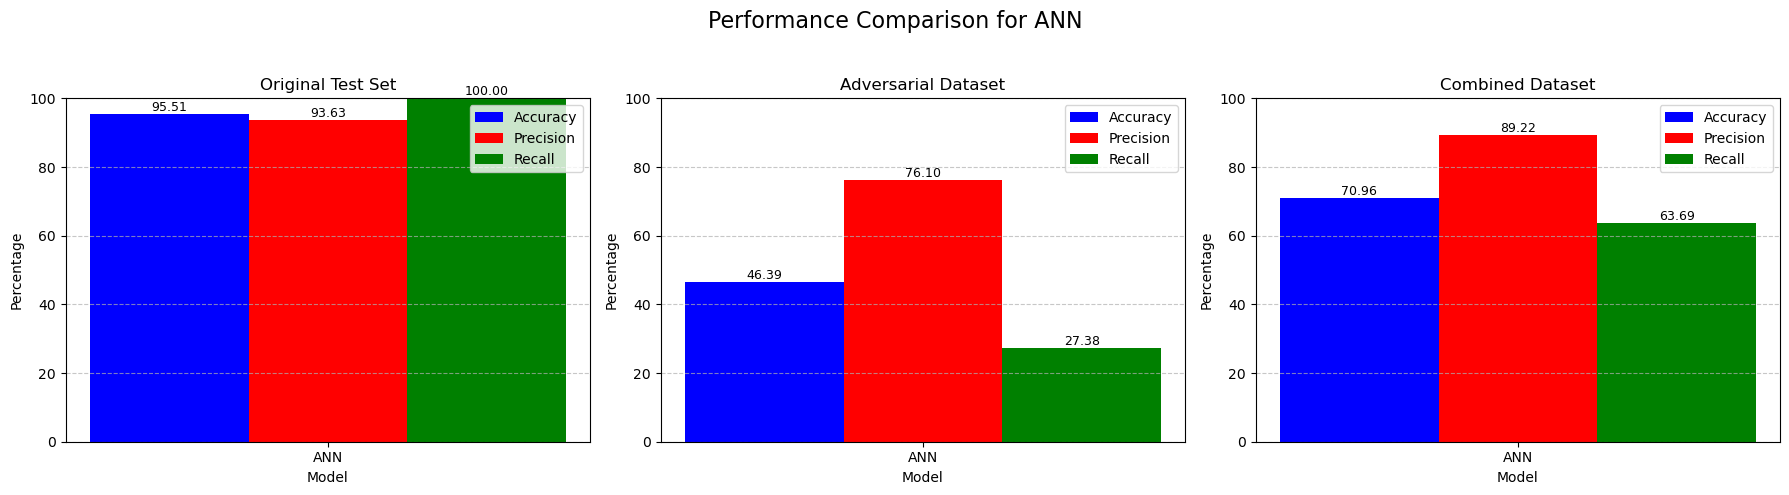

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Performance Comparison for ANN', fontsize=16)

# Original Test Set
accuracy_orig = accuracy_score(y_test, y_pred_ann) * 100
precision_orig = precision_score(y_test, y_pred_ann) * 100
recall_orig = recall_score(y_test, y_pred_ann) * 100

x = np.arange(1)
width = 0.2
bars1 = axes[0].bar(x - width, [accuracy_orig], width, label='Accuracy', color='blue')
bars2 = axes[0].bar(x, [precision_orig], width, label='Precision', color='red')
bars3 = axes[0].bar(x + width, [recall_orig], width, label='Recall', color='green')
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Percentage")
axes[0].set_title("Original Test Set")
axes[0].set_xticks(x)
axes[0].set_xticklabels(["ANN"])
axes[0].set_ylim(0, 100)
for bars, values in [(bars1, [accuracy_orig]), (bars2, [precision_orig]), (bars3, [recall_orig])]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2, height, f'{value:.2f}', ha='center', va='bottom', fontsize=9)
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Adversarial Dataset
accuracy_adv = accuracy_score(y_adv, y_pred_ann_adv) * 100
precision_adv = precision_score(y_adv, y_pred_ann_adv) * 100
recall_adv = recall_score(y_adv, y_pred_ann_adv) * 100

bars1 = axes[1].bar(x - width, [accuracy_adv], width, label='Accuracy', color='blue')
bars2 = axes[1].bar(x, [precision_adv], width, label='Precision', color='red')
bars3 = axes[1].bar(x + width, [recall_adv], width, label='Recall', color='green')
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Percentage")
axes[1].set_title("Adversarial Dataset")
axes[1].set_xticks(x)
axes[1].set_xticklabels(["ANN"])
axes[1].set_ylim(0, 100)
for bars, values in [(bars1, [accuracy_adv]), (bars2, [precision_adv]), (bars3, [recall_adv])]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2, height, f'{value:.2f}', ha='center', va='bottom', fontsize=9)
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Combined Dataset
accuracy_combined = accuracy_score(y_combined, y_pred_ann_combined) * 100
precision_combined = precision_score(y_combined, y_pred_ann_combined) * 100
recall_combined = recall_score(y_combined, y_pred_ann_combined) * 100

bars1 = axes[2].bar(x - width, [accuracy_combined], width, label='Accuracy', color='blue')
bars2 = axes[2].bar(x, [precision_combined], width, label='Precision', color='red')
bars3 = axes[2].bar(x + width, [recall_combined], width, label='Recall', color='green')
axes[2].set_xlabel("Model")
axes[2].set_ylabel("Percentage")
axes[2].set_title("Combined Dataset")
axes[2].set_xticks(x)
axes[2].set_xticklabels(["ANN"])
axes[2].set_ylim(0, 100)
for bars, values in [(bars1, [accuracy_combined]), (bars2, [precision_combined]), (bars3, [recall_combined])]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2, height, f'{value:.2f}', ha='center', va='bottom', fontsize=9)
axes[2].legend()
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()